In [155]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline
from KAGGLE_NLP_with_disaster_tweets.model import constants

In [157]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
max_vocabulary_size = 20000
glove_embedding_dim = 200

In [158]:
data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name,
                             output_sequence_length=40,
                             max_vocabulary_size=max_vocabulary_size,
                             glove_embedding_dim=glove_embedding_dim,
                             glove_url=constants.glove_url['twitter.27B'])
dataset = data_pipeline.prepare_dataset(include_cols=["location", "keyword"], apply_preprocessing=True)
dataframe = data_pipeline.dataframe

Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7526
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3      people receive wildfires evacuation orders in...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                                                 ...     ...  
7608  

## Plot the character count in the tweets

<AxesSubplot:ylabel='Frequency'>

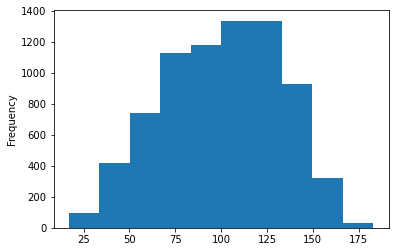

In [159]:
tweet_lengths = dataframe["text"].map(lambda tweet: len(tweet))
tweet_lengths.plot(kind='hist')

## Plot the word count in the tweets

<AxesSubplot:ylabel='Frequency'>

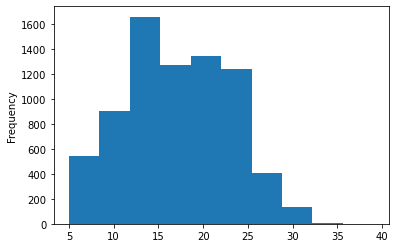

In [160]:
# naive assumption: split words by space char
tweet_lengths = dataframe["text"].map(lambda tweet: len(tweet.split(" ")))
tweet_lengths.plot(kind='hist')

## Plot the class distribution

<AxesSubplot:>

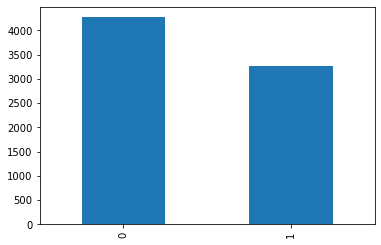

In [161]:
dataframe["target"].value_counts().plot(kind='bar')

### It can be easily seen that the classes are not distributed evenly.

In [162]:
dataframe[(dataframe['keyword'] == 'ablaze') & (dataframe['target'] == 1)]

,id,keyword,location,text,target
31,48,ablaze,birmingham,ablaze birmingham user wholesale markets ablaz...,1
33,50,ablaze,africa,ablaze africa africanbaze breaking newsnigeria...,1
37,55,ablaze,worldwide,ablaze worldwide inec office in abia set ablaz...,1
38,56,ablaze,,ablaze barbados bridgetown jamaica two cars se...,1
46,66,ablaze,greensboronorthcarolina,ablaze greensboronorthcarolina how the west wa...,1
50,73,ablaze,sheffieldtownshipohio,ablaze sheffieldtownshipohio deputies man shot...,1
51,74,ablaze,india,ablaze india man wife get six years jail for s...,1
53,77,ablaze,anaheim,ablaze anaheim police arsonist deliberately se...,1
55,79,ablaze,usa,ablaze usa kurds trampling on turkmen flag lat...,1
56,80,ablaze,southafrica,ablaze southafrica truck ablaze r voortrekke...,1


## Check the keyword frequency in the dataset

In [163]:
keywords = dataframe['keyword'].unique().tolist()
keyword_counts = {}
keywords_by_labels = []
for keyword in keywords:
    keyword_counts[keyword] = dataframe['keyword'].where(dataframe['keyword'] == keyword).count()
    keywords_by_labels.append({
        'keyword': keyword,
        'true': dataframe.where((dataframe['keyword'] == keyword) & (dataframe['target'] == 1))['id'].count(),
        'false': dataframe.where((dataframe['keyword'] == keyword) & (dataframe['target'] == 0))['id'].count()
    })
print(keyword_counts)

{'': 46, 'ablaze': 36, 'accident': 35, 'aftershock': 32, 'airplane accident': 35, 'ambulance': 38, 'annihilated': 34, 'annihilation': 29, 'apocalypse': 31, 'armageddon': 40, 'army': 34, 'arson': 32, 'arsonist': 33, 'attack': 36, 'attacked': 35, 'avalanche': 30, 'battle': 26, 'bioterror': 37, 'bioterrorism': 30, 'blaze': 38, 'blazing': 34, 'bleeding': 35, 'blew up': 33, 'blight': 31, 'blizzard': 35, 'blood': 34, 'bloody': 35, 'blown up': 33, 'body bag': 33, 'body bagging': 33, 'body bags': 41, 'bomb': 34, 'bombed': 38, 'bombing': 29, 'bridge collapse': 35, 'buildings burning': 35, 'buildings on fire': 33, 'burned': 33, 'burning': 34, 'burning buildings': 37, 'bush fires': 25, 'casualties': 35, 'casualty': 33, 'catastrophe': 36, 'catastrophic': 30, 'chemical emergency': 33, 'cliff fall': 36, 'collapse': 34, 'collapsed': 34, 'collide': 34, 'collided': 40, 'collision': 39, 'crash': 33, 'crashed': 34, 'crush': 37, 'crushed': 29, 'curfew': 37, 'cyclone': 32, 'damage': 41, 'danger': 36, 'dead

<AxesSubplot:>

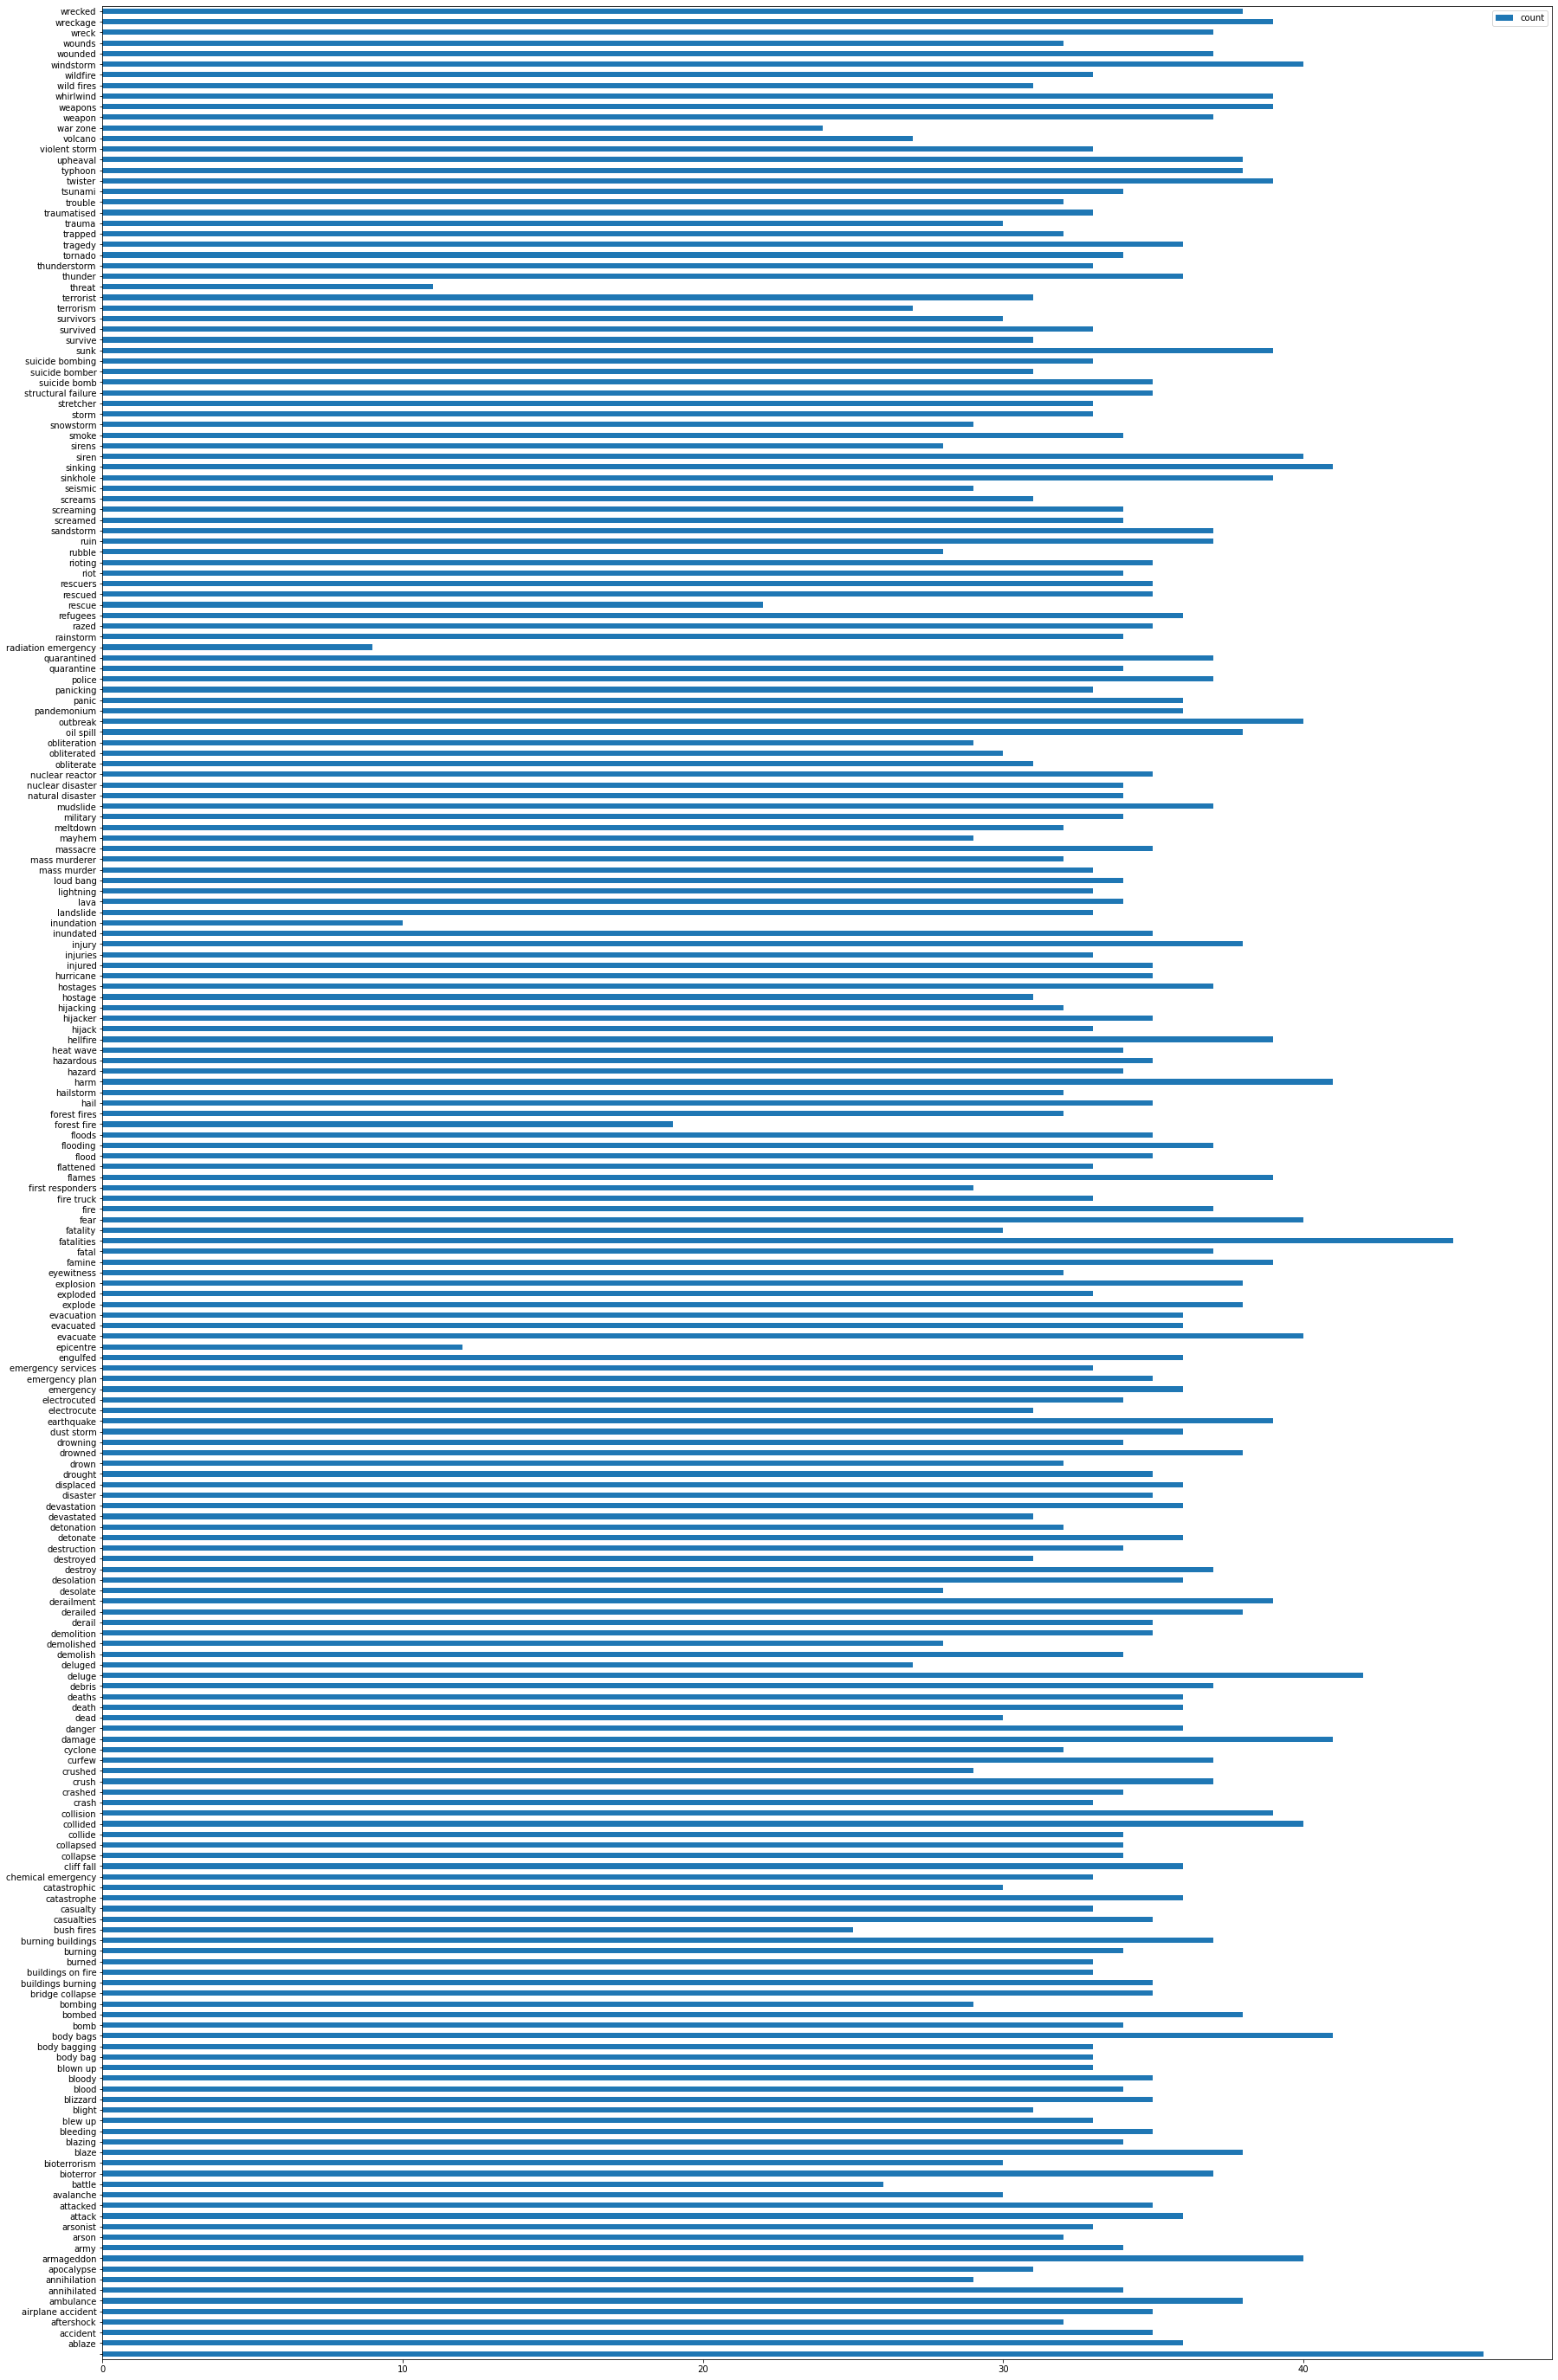

In [164]:
keyword_count_df = pd.DataFrame({"keyword": keyword_counts.keys(), "count": keyword_counts.values()}, index=keyword_counts.keys())
keyword_count_df.plot.barh(figsize=(30, 50))
# keyword_count_df

In [165]:
keywords_by_labels

[{'keyword': '', 'true': 41, 'false': 5},
 {'keyword': 'ablaze', 'true': 13, 'false': 23},
 {'keyword': 'accident', 'true': 24, 'false': 11},
 {'keyword': 'aftershock', 'true': 0, 'false': 32},
 {'keyword': 'airplane accident', 'true': 30, 'false': 5},
 {'keyword': 'ambulance', 'true': 20, 'false': 18},
 {'keyword': 'annihilated', 'true': 11, 'false': 23},
 {'keyword': 'annihilation', 'true': 10, 'false': 19},
 {'keyword': 'apocalypse', 'true': 9, 'false': 22},
 {'keyword': 'armageddon', 'true': 4, 'false': 36},
 {'keyword': 'army', 'true': 5, 'false': 29},
 {'keyword': 'arson', 'true': 22, 'false': 10},
 {'keyword': 'arsonist', 'true': 8, 'false': 25},
 {'keyword': 'attack', 'true': 25, 'false': 11},
 {'keyword': 'attacked', 'true': 21, 'false': 14},
 {'keyword': 'avalanche', 'true': 4, 'false': 26},
 {'keyword': 'battle', 'true': 5, 'false': 21},
 {'keyword': 'bioterror', 'true': 22, 'false': 15},
 {'keyword': 'bioterrorism', 'true': 21, 'false': 9},
 {'keyword': 'blaze', 'true': 5, 

In [166]:
df = pd.DataFrame(keywords_by_labels)

In [167]:
df

,keyword,true,false
0,,41,5
1,ablaze,13,23
2,accident,24,11
3,aftershock,0,32
4,airplane accident,30,5
...,...,...,...
217,wounded,26,11
218,wounds,10,22
219,wreck,7,30
220,wreckage,39,0


## Check the keyword instances by their labels

In [168]:
import math

def visualize_keywords_by_labels(df: pd.DataFrame, num_figs: int):
    step_size = math.ceil(len(df) / num_figs)
    col_names = df.columns.names;
    fig, axs = plt.subplots(num_figs)

    # first slice the dataframe into num_figs parts
    for i in range(0, num_figs):
        sliced_df = df[i*step_size:(i+1)*step_size]
        indices = np.arange(len(sliced_df))
        width = 0.4

        axs[i].barh(indices, sliced_df.true, width, color='green', label='1')
        axs[i].barh(indices + width, sliced_df.false, width, color='red', label='0')

        axs[i].set(yticks=indices+width, yticklabels=sliced_df.keyword, ylim=[2*width - 1, len(sliced_df)])
        axs[i].legend()
        # axs[i]
    fig.set_size_inches(10, 20, forward=True)
    plt.show()

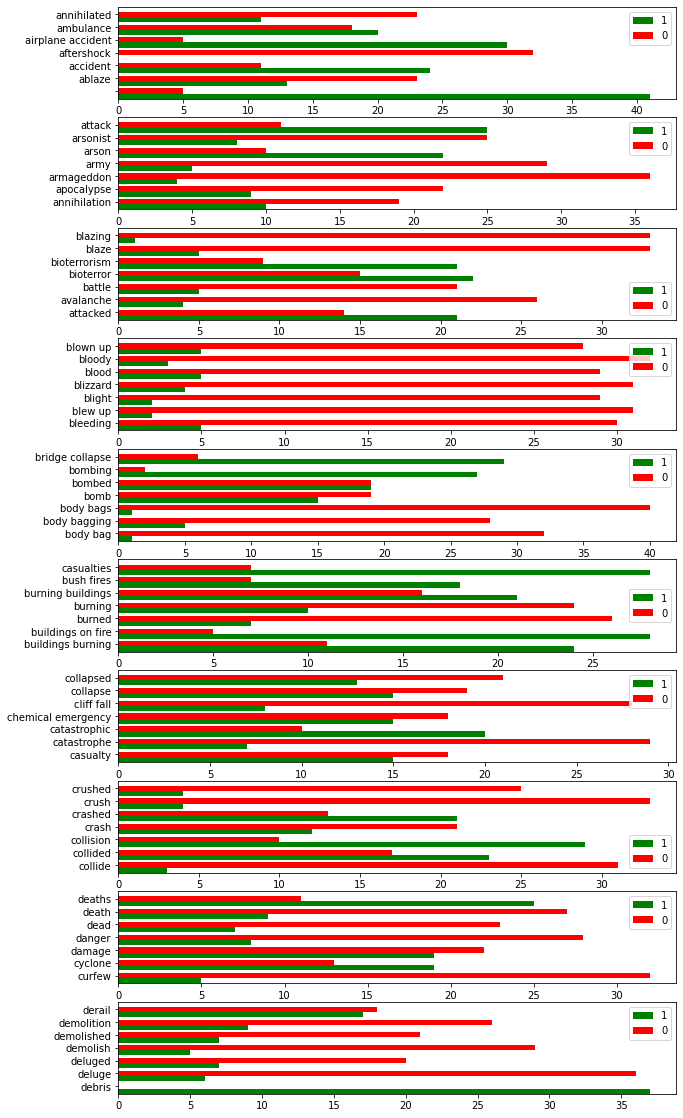

In [169]:
visualize_keywords_by_labels(df[0:70], 10)

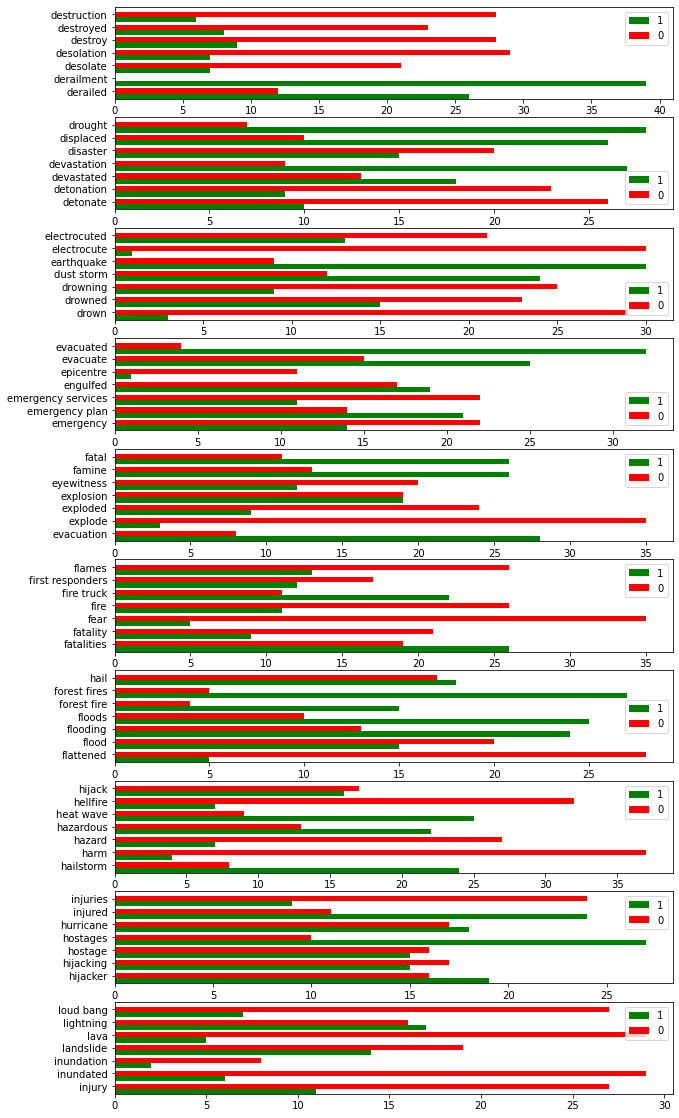

In [170]:
visualize_keywords_by_labels(df[70:140], 10)

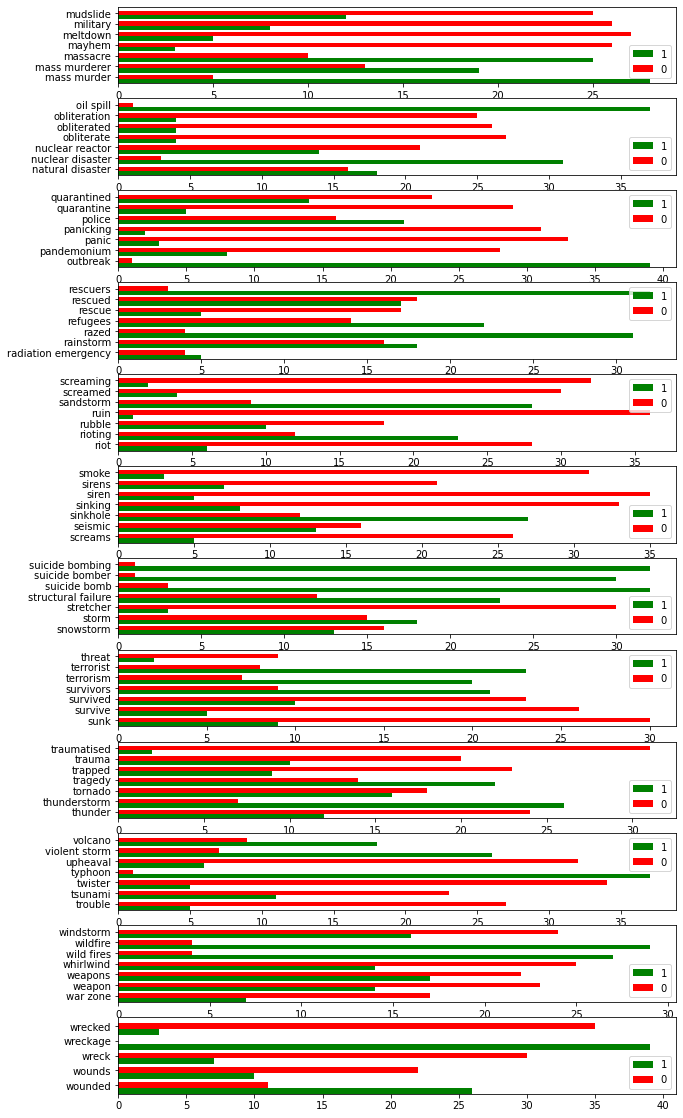

In [171]:
visualize_keywords_by_labels(df[140:], 12)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

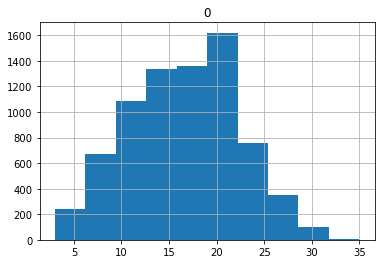

In [172]:
# we want to see the length of each input after vectorization
dataset_inputs = dataset.map(lambda x, y: x)
inputs_dataframe = pd.DataFrame(dataset_inputs.as_numpy_iterator())
inputs_len_list = []
# truncate the list at the first occurrence of 0
for idx, row in inputs_dataframe.iterrows():
    inputs_len_list.append(len(row.values[0:row.values.tolist().index(0)]))
# convert to df for convenience
inputs_len_list = pd.DataFrame(inputs_len_list)

inputs_len_list.hist()